# Data Exploration: Online Conformal

In this notebook, we are testing the code for Salesforce's implementations of online conformal models. The Python version used is Python 3.8.20 (base environment).

## Preliminaries

In [1]:
# imports
import duckdb
import matplotlib.pyplot as plt
from merlion.models.factory import ModelFactory
from online_conformal.dataset import M4
from online_conformal.visualize import plot_simulated_forecast

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Reading in data

In [2]:
regn_data = duckdb.sql(
    """select * 
       from 'test_data/regn_20230103_to_20230331.csv.gz' 
       where DATE = '2023-01-03'
       order by TIME_M """).df()

In [3]:
regn_data

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_STOP_IND,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF
0,2023-01-03,04:00:00.166684,P,REGN,None,@ TI,1,743.14,None,00,1950,1,N,None
1,2023-01-03,04:33:58.480628,K,REGN,None,@ TI,10,724.00,None,00,5944,1,N,None
2,2023-01-03,04:33:58.510989,P,REGN,None,@ TI,1,723.12,None,00,5945,2,N,None
3,2023-01-03,04:34:03.641957,K,REGN,None,@ TI,7,724.00,None,00,5968,2,N,None
4,2023-01-03,07:08:43.989827,P,REGN,None,@FTI,1,725.00,None,00,29310,3,N,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17114,2023-01-03,16:35:21.799020,D,REGN,None,@ TI,10,720.47,None,00,5045639,3559,N,Q
17115,2023-01-03,16:53:35.057812,D,REGN,None,@ TW,2131,720.47,None,00,5048337,3560,N,Q
17116,2023-01-03,18:34:47.018832,K,REGN,None,@ TI,1,712.43,None,00,5054550,718,N,None
17117,2023-01-03,19:51:44.317380,P,REGN,None,@FTI,10,718.80,None,00,5062153,1620,N,None


A simple visual of REGN's stock price:

In [4]:
regn_data["dollar_volume"] = regn_data["PRICE"] * regn_data["SIZE"]

<AxesSubplot:>

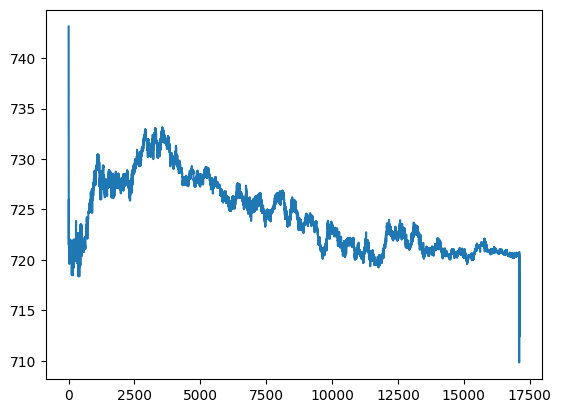

In [5]:
regn_data.PRICE.plot()

<AxesSubplot:>

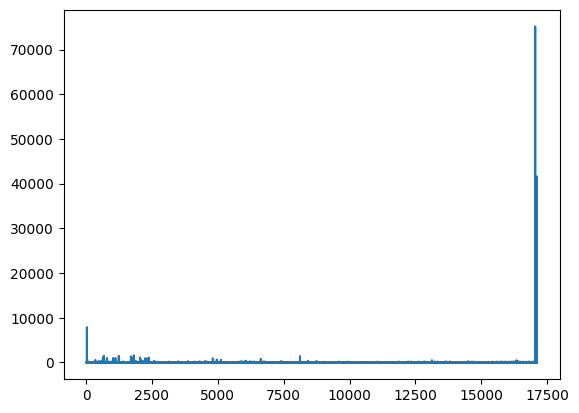

In [6]:
regn_data.SIZE.plot()

## Test Online Conformal Model

Below is an example from the ``online_conformal`` README which we will use for reference.

In [7]:
import pandas as pd
from merlion.models.factory import ModelFactory
from merlion.utils import TimeSeries
from online_conformal.dataset import M4
from online_conformal.saocp import SAOCP

# Get some time series data as pandas.DataFrames
data = M4("Hourly")[0]
train_data, test_data = data["train_data"], data["test_data"]
# Initialize a Merlion model for time series forecasting
model = ModelFactory.create(name="LGBMForecaster")
# Initialize the SAOCP wrapper on top of the model. This splits the data 
# into train/calibration splits, trains the model on the train split, 
# and initializes SAOCP's internal state on the calibration split.
# The target coverage is 90% here, but you can adjust this freely.
# We also do 24-step-ahead forecasting by setting horizon=24.
horizon = 24
saocp = SAOCP(model=model, train_data=train_data, coverage=0.9,
              calib_frac=0.2, horizon=horizon)

# Get the model's 24-step-ahead prediction, and convert it to prediction intervals
yhat, _ = saocp.model.forecast(horizon, time_series_prev=TimeSeries.from_pd(train_data))
delta_lb, delta_ub = zip(*[saocp.predict(horizon=h + 1) for h in range(horizon)])
yhat = yhat.to_pd().iloc[:, 0]
lb, ub = yhat + delta_lb, yhat + delta_ub

# Update SAOCP's internal state based on the next 24 observations
prev = train_data.iloc[:-horizon + 1]
time_series = pd.concat((train_data.iloc[-horizon + 1:], test_data.iloc[:horizon]))
for i in range(len(time_series)):
    # Predict yhat_{t-H+i+1}, ..., yhat_{t-H+i+H} = f(y_1, ..., y_{t-H+i}) 
    y = time_series.iloc[i:i + horizon, 0]
    yhat, _ = saocp.model.forecast(y.index, time_series_prev=TimeSeries.from_pd(prev))
    yhat = yhat.to_pd().iloc[:, 0]
    # Use h-step prediction of yhat_{t-k+h} to update SAOCP's h-step prediction interval
    for h in range(len(y)):
        if i >= h:
            saocp.update(ground_truth=y[h:h + 1], forecast=yhat[h:h + 1], horizon=h + 1)
    prev = pd.concat((prev, time_series.iloc[i:i+1]))

Inferred granularity <Hour>


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7296
[LightGBM] [Info] Number of data points in the train set: 454, number of used features: 48
[LightGBM] [Info] Start training from score 0.498878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Now, we'll try to test this on a day's worth of data.

In [8]:
import logging
logging.basicConfig(level=logging.ERROR)

import matplotlib.pyplot as plt
from merlion.models.factory import ModelFactory
from online_conformal.dataset import M4
from online_conformal.visualize import plot_simulated_forecast
from time_series import evaluate, summarize_results, visualize

In [9]:
# get training size
train_size = round(len(regn_data.PRICE) * 0.7)

In [10]:
# get datetime column
regn_data["timestamp"] = pd.to_datetime(regn_data['DATE']) + pd.to_timedelta(regn_data['TIME_M'].astype(str))

# train-test split
train_vals, test_vals = regn_data[["timestamp", "PRICE"]][:train_size].set_index("timestamp"), regn_data[["timestamp", "PRICE"]][train_size:].set_index("timestamp")

In [11]:
# Initialize a Merlion model for time series forecasting
model = ModelFactory.create(name="Arima")

In [12]:
# Initialize the SAOCP wrapper on top of the model. This splits the data 
# into train/calibration splits, trains the model on the train split, 
# and initializes SAOCP's internal state on the calibration split.
# The target coverage is 90% here, but you can adjust this freely.
# We also do 24-step-ahead forecasting by setting horizon=24.
horizon = 24
saocp = SAOCP(model=model, train_data=train_vals, coverage=0.9,
              calib_frac=0.2, horizon=horizon)

/opt/anaconda3/lib/python3.8/site-packages/merlion/utils/resample.py:155: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  dt = pd.to_timedelta(scipy.stats.mode(orig_t[1:] - orig_t[:-1], axis=None)[0].item())


ValueError: cannot convert float NaN to integer

Base code needs some tweaking to use only pretrained models, as the current implementation relies on the Merlion code base to train the model. Should be able to repurpose the Salesforce code with citations.